# Análisis de MNIST con tf.keras, tf.data y eager execution

**Profesor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />

**Colaborador:** Sebastián Arpón <br />
**E-mail:** <rmunoz@metricarts.com> <br />

En este laboratorio crearemos una red neuronal que pueda detectar a que digito corresponde una imagen que recibe (note que cada imagen contendra solo un digito). Utilizaremos la API `tf.data` [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) la cual es muy eficiente e incluye funcionalidades como el shuffling y batching. 

El conjunto de datos con el que trabajaremos es el MINST el cual, como veremos mas adelante esta incluido en KERAS.

In [1]:
import tensorflow as tf

# Activando Eager
tf.enable_eager_execution()

import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
tf.__version__

'1.8.0'

## Usamos la API de keras para descargar el dataset de MNIST

In [3]:
# obteniendo la data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [4]:
print("Tamaño train dataset: ", len(train_labels))

np.unique(train_labels)

Tamaño train dataset:  60000


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [5]:
print("Tamaño test dataset: ", len(test_labels))

np.unique(test_labels)

Tamaño test dataset:  10000


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Revisamos el tamaño de train_images y train_labels

In [6]:
print("Train images")
print("Tipo: ", type(train_images))
print("Nº de elementos: ", len(train_images))
print("Dimensiones: ", train_images.shape)

Train images
Tipo:  <class 'numpy.ndarray'>
Nº de elementos:  60000
Dimensiones:  (60000, 28, 28)


In [7]:
print("Train labels")
print("Tipo: ", type(train_labels))
print("Nº de elementos: ", len(train_labels))
print("Dimensiones: ", train_labels.shape)

Train labels
Tipo:  <class 'numpy.ndarray'>
Nº de elementos:  60000
Dimensiones:  (60000,)


In [8]:
train_labels[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

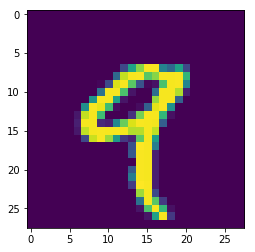

In [11]:
plt.imshow(train_images[4,:,:])

## Revisamos un par de imágenes del dataset train

Indice del registro:  54596
Label:  8
Tamaño en pixels:  (28, 28)


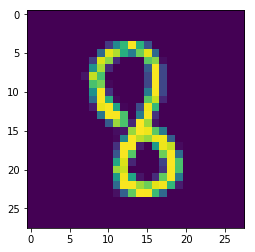

In [16]:
i=np.random.randint(len(train_images))

print("Indice del registro: ", i)
print("Label: ", train_labels[i])
print("Tamaño en pixels: ", train_images[i].shape)
plt.imshow(train_images[i,:,:])

## Transformamos train_images y test_images

Transformamos train_images y test_images de matrices de 28x28 a un vector de largo 784

In [17]:
# Chequeando el tamaño de los conjuntos de entrenamiento y test
TRAINING_SIZE = len(train_images)
TEST_SIZE = len(test_images)

# transformando desde (N, 28, 28) a (N, 784)
train_images = np.reshape(train_images, (TRAINING_SIZE, 784))
test_images = np.reshape(test_images, (TEST_SIZE, 784))

# Transformando cada arreglo desde uint8 a float32
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

# Convirtiendo cada valor desde [0,255] a [0,1] 
train_images /= 255
test_images /=  255

In [18]:
print("Train images")
print(len(train_images))
print(train_images.shape)

Train images
60000
(60000, 784)


In [19]:
print("Test images")
print(len(test_images))
print(test_images.shape)

Test images
10000
(10000, 784)


## Transformamos las etiquetas en un vector 

Usamos la función **tf.keras.utils.to_categorical** del módulo **tf.keras** para transformar cada valor de etiqueta a un vector conformato categórico.

En el caso de usar la función de costo **categorical_crossentropy**, las etiquetas deben ser transformadas en formato categórico. Si tenemos 10 clases, entonces cada etiqueta debe ser transformado en un vector de largo 10 donde **todos los valores son cero** excepto el índice correspondiente a la clase el cual tendrá el **valor uno**.

In [20]:
if 'train_labels_ORIG' not in locals():
    train_labels_ORIG=train_labels.copy()
    
if 'test_labels_ORIG' not in locals():
    test_labels_ORIG=test_labels.copy()

In [21]:
NUM_DIGITS = 10

train_labels  = tf.keras.utils.to_categorical(train_labels_ORIG, NUM_DIGITS)
test_labels = tf.keras.utils.to_categorical(test_labels_ORIG, NUM_DIGITS)

print("Previo al cambio de formato\t: ", train_labels_ORIG[0]) # The format of the labels before conversion
print("Posterior al cambio de formato\t: ", train_labels[0]) # The format of the labels after conversion

Previo al cambio de formato	:  5
Posterior al cambio de formato	:  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [22]:
print(type(train_labels))
print(train_labels.dtype)

<class 'numpy.ndarray'>
float64


In [23]:
train_labels[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [24]:
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [25]:
print(type(train_labels))
print(train_labels.dtype)

<class 'numpy.ndarray'>
float32


In [26]:
train_labels[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.], dtype=float32)

## Definimos la arquitectura de la red neuronal con Keras

In [27]:
tf.keras.backend.clear_session()

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(300, activation=tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

## Definimos el optimizador que usaremos

Esto es obligatorio mientras usamos eager execution

Usaremos el optimizador RMS Propagation

Más info en https://www.tensorflow.org/api_guides/python/train#Optimizers

In [29]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

## Elegimos la función de costo y compilamos el modelo

Usaremos la función de costo categorical_crossentropy

Más info de losses en https://www.tensorflow.org/api_docs/python/tf/keras/losses

Más info de metrics en https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


## 1. Entrenamos el modelo usando tf.data y train_on_batch()

### Paso 1 - Creamos un dataset del tipo tf.data

Ahora usaremos `tf.data.Dataset` [API](https://www.tensorflow.org/api_docs/python/tf/data) para convertir los arreglos de Numpy en un dataset de TensorFlow

A continuacion crearemos un ciclo **for** que servira como una introduccion en la creacion de ciclos de entrenamientos personalizados. Aunque esencialmente estos ciclos hacer lo mismo que `model.fit`, esto nos permite personalizar todo el proceso y recolectar distintas metricas.

Usamos un batch size de 128 elementos

In [31]:
BATCH_SIZE=128

# Dado que tf.data puede funcionar en colecciones de datos potencialmente grandes
# La desordenaremos por partes.
SHUFFLE_SIZE = 10000 

# Creando el dataset
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.shuffle(SHUFFLE_SIZE)
dataset = dataset.batch(BATCH_SIZE)

### Step 2 - Definimos las epocas de entrenamiento y entrenamos

Aca entrenaremos sobre el dataset usando los distintos batch.

In [32]:
EPOCHS=5

for epoch in range(EPOCHS):
    for images, labels in dataset:
        train_loss, train_accuracy = model.train_on_batch(images, labels)
  
  # Obtenemos cualquier metrica o ajustamos los parametros de entrenamiento
    print('Epoch #%d\t Loss: %.6f\tAccuracy: %.6f' % (epoch + 1, train_loss, train_accuracy))
  

Epoch #1	 Loss: 0.167212	Accuracy: 0.958333
Epoch #2	 Loss: 0.071764	Accuracy: 0.979167
Epoch #3	 Loss: 0.081332	Accuracy: 0.968750
Epoch #4	 Loss: 0.013837	Accuracy: 1.000000
Epoch #5	 Loss: 0.054777	Accuracy: 0.968750


In [33]:
loss, accuracy = model.evaluate(test_images, test_labels)
print('Test accuracy: %.2f' % (accuracy))

10000/10000 [==============================] - 1s 104us/step
Test accuracy: 0.98


## 2. Entrenamos el modelo usando fit()

### Paso 1 - Creamos una función que define el modelo

Usaremos **sparse_categorical_crossentropy**

In [34]:
# Returns a short sequential model
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(784,)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
  
    model.compile(optimizer=tf.train.AdamOptimizer(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
  
    return model


# Create a basic model instance
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


### Paso 2 - Entrenamos el modelo usando fit()

Dado que usaremos la función de costo **tf.keras.losses.sparse_categorical_crossentropy**, las etiquetas deben ser valores simples y no vectores

In [35]:
train_labels = train_labels_ORIG.copy()
test_labels = test_labels_ORIG.copy()

In [36]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [37]:
EPOCHS=5
checkpoint_dir = "results"

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [38]:
checkpoint_path = os.path.join(checkpoint_dir, "model_mnist_{epoch:04d}.ckpt")

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                checkpoint_path, verbose=1, save_weights_only=True,
                # Save weights, every 1-epochs
                period=1)
                                                 

model = create_model()

model.fit(train_images, train_labels,  epochs = EPOCHS, 
          validation_data = (test_images, test_labels),
          callbacks = [cp_callback])  # pass callback to training

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
59968/60000 [============================>.] - ETA: 0s - loss: 0.2213 - acc: 0.9343
Epoch 00001: saving model to results/model_mnist_0001.ckpt
60000/60000 [==============================] - 28s 464us/step - loss: 0.2212 - acc: 0.9344 - val_loss: 0.1025 - val_acc: 0.9670
Epoch 2/5
59968/60000 [============================>.] - ETA: 0s - loss: 0.0958 - acc: 0.9710
Epoch 00002: saving model to results/model_mnist_0002.ckpt
60000/60000 [==============================] - 30s 506us/step - loss: 0.0957 - acc: 0.9710 - val_loss: 0.0828 - val_acc: 0.9728
Epoch 3/5
59872/60000 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9788
Epoch 00003: saving model to results/model_mnist_0003.ckpt
60000/60000 [==============================] - 30s 501us/step - loss: 0.0677 - acc: 0.9788 - val_loss: 0.0735 - val_acc: 0.9767
Epoch 4/5
59904/60000 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9829
Epoch 00004: 

## Evaluamos el modelo recién entrenado

In [39]:
loss, acc = model.evaluate(test_images, test_labels)

print("Model accuracy: {:5.2f}%".format(100*acc))

10000/10000 [==============================] - 2s 174us/step
Model accuracy: 98.19%


## Restauramos una época del modelo

In [40]:
import glob

pattern = os.path.join(checkpoint_dir, "*.ckpt")
checkpoints = sorted(glob.glob(pattern))

for file in checkpoints:
    print(file)

results/model_mnist_0001.ckpt
results/model_mnist_0002.ckpt
results/model_mnist_0003.ckpt
results/model_mnist_0004.ckpt
results/model_mnist_0005.ckpt


In [41]:
weight_file = 'results/model_mnist_0001.ckpt'

model = create_model()
model.load_weights(weight_file)
loss, acc = model.evaluate(test_images, test_labels)

print("Restored model - accuracy: {:5.2f}%".format(100*acc))

10000/10000 [==============================] - 1s 138us/step
Restored model - accuracy: 96.70%
